In [1]:
import os
import torch
from datasets import Dataset, DatasetDict
from transformers import (
    GPT2Config, 
    GPT2LMHeadModel,
    AutoModelForCausalLM,
    Trainer, 
    TrainingArguments,
    DataCollatorForLanguageModeling,
    PreTrainedTokenizerFast,
    pipeline
)
import numpy as np
from triangle_free import greedy_search_from_startpoint, empty_starting_point, reward_calc
from typing import List, Tuple
from tokenizers import Tokenizer
from tokenizers.models import BPE
from tqdm.auto import tqdm
import random
import logging
import matplotlib.pyplot as plt
from multiprocessing import Pool
from tokenizers.trainers import BpeTrainer
from tokenizers.pre_tokenizers import Whitespace
import pickle

# Set TOKENIZERS_PARALLELISM environment variable
os.environ['TOKENIZERS_PARALLELISM'] = 'false'

# Set device
device = "cuda:2" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda:2


In [2]:
# Load the GPT2 model from the specified directory and move it to the specified device
model = GPT2LMHeadModel.from_pretrained("results/model_generation_1")
model = model.to(device)
model.eval()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(103, 16)
    (wpe): Embedding(50, 16)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-1): 2 x GPT2Block(
        (ln_1): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D(nf=48, nx=16)
          (c_proj): Conv1D(nf=16, nx=16)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=64, nx=16)
          (c_proj): Conv1D(nf=16, nx=64)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=16, out_features=103, bias=False)
)

In [3]:
VOCAB_SIZE = 100
GEN_BATCH_SIZE = 10000
BLOCK_SIZE = 50

In [4]:
# Load the best dataset
print("Loading the best dataset...")
best_dataset = Dataset.load_from_disk("data/dataset_N20_samples10000_best")

# Initialize and train tokenizer using HF interfaces
print("Initializing and training the tokenizer...")
raw_tokenizer = Tokenizer(BPE())
raw_tokenizer.pre_tokenizer = Whitespace()

# Train the tokenizer
trainer = BpeTrainer(vocab_size=VOCAB_SIZE)
raw_tokenizer.train_from_iterator(best_dataset['text'][:5000], trainer=trainer)

# Save the tokenizer to disk for reuse
# tokenizer_path = "data/tokenizer_N20_samples5000"
# os.makedirs(tokenizer_path, exist_ok=True)
# raw_tokenizer.save(f"{tokenizer_path}/tokenizer.json")

# Create a HF wrapper for the tokenizer
tokenizer = PreTrainedTokenizerFast(
    tokenizer_object=raw_tokenizer,
    bos_token="<s>",
    eos_token="</s>",
    pad_token="<pad>"
)

Loading the best dataset...
Initializing and training the tokenizer...





In [13]:
generator = pipeline(
        "text-generation",
        model=model,
        tokenizer=tokenizer,
        device=device
    )
    
decoded_samples = []

# Generate in batches to manage memory
batch_size = GEN_BATCH_SIZE  # Smaller batch size for generation
num_batches = (40000 + batch_size - 1) // batch_size

for i in tqdm(range(num_batches)):
    try:
        outputs = generator(
            [tokenizer.bos_token],
            max_length=BLOCK_SIZE,
            do_sample=True,
            temperature=1.0,
            num_return_sequences=batch_size, # can do better ?
            pad_token_id=tokenizer.eos_token_id
        )
        
        # Process generated texts
        for output in outputs[0]:
            text = output['generated_text']
            # Remove special tokens and extra spaces
            text = text.replace(tokenizer.bos_token, "").replace(" ", "")
            if len(text) >= 190:
                decoded_samples.append(text[:190])
        
        # Clear cache
        torch.cuda.empty_cache()
    except RuntimeError as e:
        print(f"Runtime error during generation: {e}")
        print("Reducing batch size and continuing...")
        batch_size = max(1, batch_size // 2)

print(f"Generated {len(decoded_samples)} samples.")

  0%|          | 0/4 [00:00<?, ?it/s]

Generated 39869 samples.


In [12]:
outputs[0][10]

{'generated_text': '<s>00100011 0100001 0100001 0 000111 00001111 01001 0010101 00100001 00010000 00001011 01001 0011 00000011 01011 00010000 11 0001 01000011 001111 0011 0010011 01010101 0001011 010001 00111 010011 0010000 0100001 000111 0110000 0100001 0011 0100001 010111 000011 01001 0011 0111 01001 00011 010000 001111 0010101 010000 01111 01111 0001011 00100011'}

In [14]:
decoded_samples

['0101110000100111000100110001000000010000001000010101001010010101101000001001000000011100001111011001000101100000010001100001110010001010100000100010011001110010010001110001101000001001001011',
 '0100001001100011000110100011000001001000100100100111010000011001011001000101010101010100011001010010010010010010100100001101100011100100001001000100011101010000011001001100010010000101010000',
 '0000001100001000000100011000000101010010101001010001100001011010000100101100010000001000010110000001100011110100011000001100000101000100101100010000001001101000000010110110010110010000100100',
 '0000011000000100110100011001110101100001110100010111001010100100011100001100110010010001011001110000100010000001001010000110100010001101010111010000100010000011110001100000110001000001011100',
 '0000101000100000011011101010000000001100010110000110000110100001100010001001100000110011101001100010011011000001010101010101000010101100101010100110000011000011000011110100110010000100000000',
 '00000110101111010000000

In [20]:
try:
    with open("samples_final.pkl", "rb") as f:
        samples = pickle.load(f)
except EOFError:
    samples = []
    
try:
    with open("rewards_final.pkl", "rb") as f:
        rewards = pickle.load(f)
except EOFError:
    rewards = []

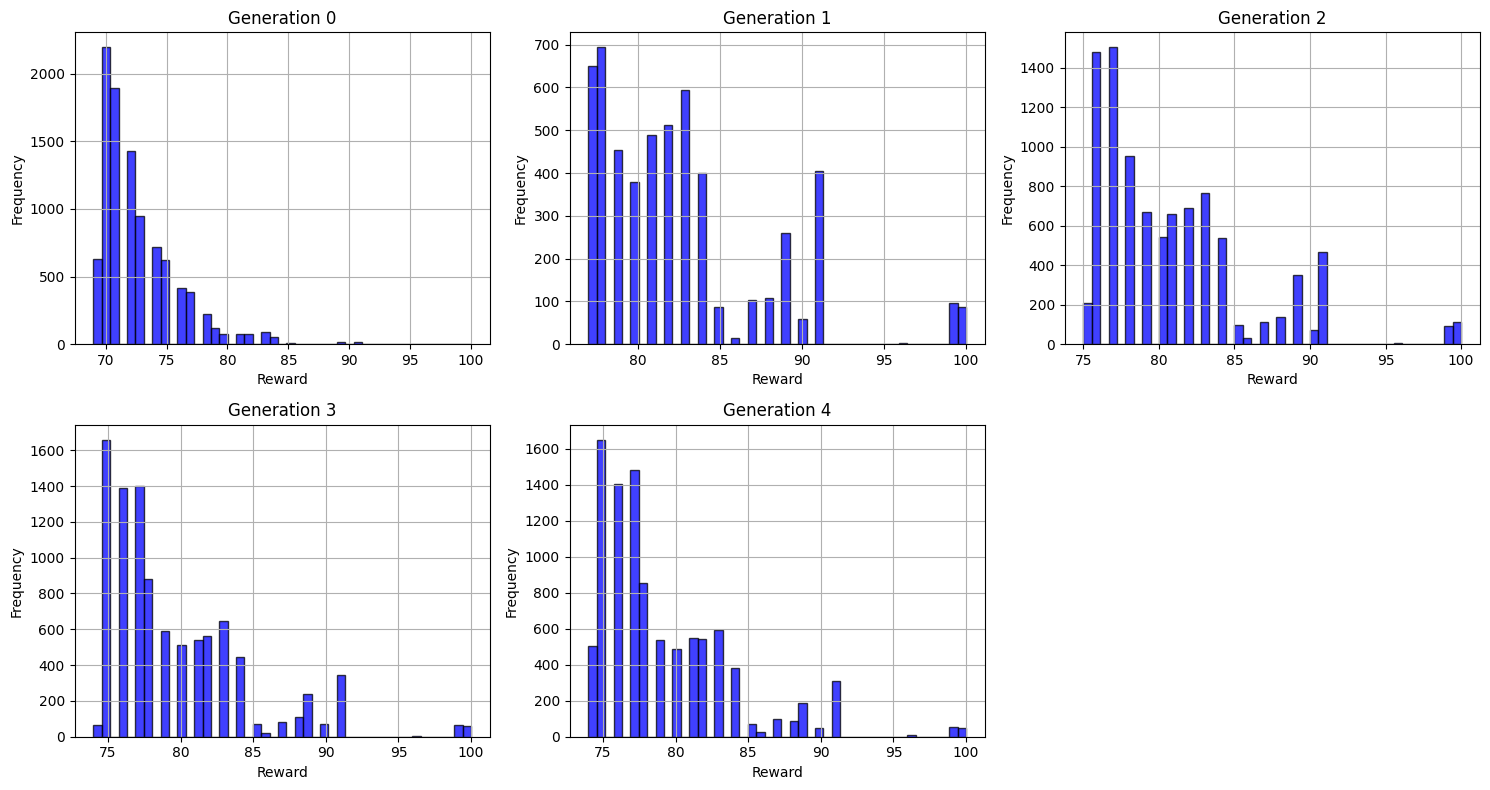

In [23]:
import math

num_plots = len(rewards)
cols = 3  # Number of columns for subplots
rows = math.ceil(num_plots / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))
axes = axes.flatten()  # flatten to ease iteration

for i, (gen, rewards) in enumerate(rewards.items()):
    axes[i].hist(rewards, bins=45, alpha=0.75, color='blue', edgecolor='black')
    axes[i].set_title(f"Generation {gen}")
    axes[i].set_xlabel("Reward")
    axes[i].set_ylabel("Frequency")
    axes[i].grid(True)

# Turn off empty subplots
for ax in axes[num_plots:]:
    ax.axis('off')

plt.tight_layout()
plt.show()

# Manual training

In [2]:
N = 20
GEN_NUM = 5
BATCH_SIZE = 512
GEN_BATCH_SIZE = 10000
MAX_STEPS = 1000
VOCAB_SIZE = 100
BLOCK_SIZE = 50
N_LAYER = 2
N_HEAD = 4
N_EMBD = 16

In [3]:
print("Loading the best dataset...")
best_dataset = Dataset.load_from_disk("data/dataset_N20_samples10000_best")

# Initialize and train tokenizer using HF interfaces
print("Initializing and training the tokenizer...")
raw_tokenizer = Tokenizer(BPE())
raw_tokenizer.pre_tokenizer = Whitespace()

# Train the tokenizer
trainer = BpeTrainer(vocab_size=VOCAB_SIZE)
raw_tokenizer.train_from_iterator(best_dataset['text'][:5000], trainer=trainer)

# Save the tokenizer to disk for reuse
# tokenizer_path = "data/tokenizer_N20_samples5000"
# os.makedirs(tokenizer_path, exist_ok=True)
# raw_tokenizer.save(f"{tokenizer_path}/tokenizer.json")

# Create a HF wrapper for the tokenizer
tokenizer = PreTrainedTokenizerFast(
    tokenizer_object=raw_tokenizer,
    bos_token="<s>",
    eos_token="</s>",
    pad_token="<pad>"
)

Loading the best dataset...
Initializing and training the tokenizer...





In [4]:
samples = {}
rewards = {}
samples[0] = best_dataset['text']
rewards[0] = best_dataset['reward']

In [5]:
gen_idx = 1

In [6]:
print("Preparing dataset for training...")
text_data = samples[gen_idx - 1]

def tokenize_function(examples):
    return tokenizer(examples["text"], 
                        padding=True, 
                        truncation=True,
                        max_length=BLOCK_SIZE)

# Create HF Dataset for the current generation
current_gen_dataset = Dataset.from_dict({"text": text_data})

# Tokenize the dataset
tokenized_datasets = current_gen_dataset.map(
    tokenize_function,
    batched=True,
    remove_columns=["text"]
)

# Split into train/eval sets
split_datasets = tokenized_datasets.train_test_split(test_size=0.1)

Preparing dataset for training...


Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [7]:
config = GPT2Config(
    vocab_size=len(tokenizer),
    n_positions=BLOCK_SIZE,
    n_embd=N_EMBD,
    n_layer=N_LAYER,
    n_head=N_HEAD,
    bos_token_id=tokenizer.bos_token_id,
    eos_token_id=tokenizer.eos_token_id,
)
model = GPT2LMHeadModel(config)
model.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(103, 16)
    (wpe): Embedding(50, 16)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-1): 2 x GPT2Block(
        (ln_1): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D(nf=48, nx=16)
          (c_proj): Conv1D(nf=16, nx=16)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=64, nx=16)
          (c_proj): Conv1D(nf=16, nx=64)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=16, out_features=103, bias=False)
)

In [8]:
training_args = TrainingArguments(
    output_dir=f"./results/generation_{gen_idx}",
    overwrite_output_dir=True,
    max_steps=MAX_STEPS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    eval_strategy="steps",
    save_strategy="no",
    eval_steps=500,
    logging_dir=f"./logs/generation_{gen_idx}",
    logging_steps=100,
    report_to="tensorboard",
    bf16=True
)

# Data collator for language modeling
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, 
    mlm=False
)

# Initialize trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=split_datasets["train"],
    eval_dataset=split_datasets["test"],
    data_collator=data_collator,
)


max_steps is given, it will override any value given in num_train_epochs


In [ ]:
trainer.train()

/home/pavutnitskiy/.pyenv/versions/myenv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss,Validation Loss
500,4.431500,4.418204
